In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-scoring/sample_submission.csv
/kaggle/input/sf-scoring/train.csv
/kaggle/input/sf-scoring/test.csv


In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [5]:
from datetime import datetime

In [6]:
# Функция для поиска выбросов в данных методом IQR
def IQR_outliers(i):
    Q1=data[i].quantile(0.25)
    Q3=data[i].quantile(0.75)
    IQR=Q3-Q1
    low=Q1-1.5*IQR
    high=Q3+1.5*IQR
    return (low,high)

In [7]:
# Загружаем данные
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [8]:
sample_submission.shape

(36349, 2)

In [9]:
df_test.shape

(36349, 18)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [11]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [13]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [14]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


**Разведывательный анализ данных (EDA)**

In [15]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [16]:
# Пропуски есть только в колонке education
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [17]:
# Видим, что в колонке client_id все значения уникальные
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [18]:
# Посчитаем вручную параметр WOE (Weight of Evidence) для колонки sex 
female_non_default=data.groupby('sex')['default'].value_counts()[0]
female_default=data.groupby('sex')['default'].value_counts()[1]
male_non_default=data.groupby('sex')['default'].value_counts()[2]
male_default=data.groupby('sex')['default'].value_counts()[3]

In [19]:
# Создадим датафрейм для работы с признаком WOE
df3=pd.DataFrame(np.array([[female_non_default,female_default],[male_non_default,male_default]]),columns=['non_default','default'],index=['female','male'])

In [20]:
df3['percent_non_default']=df3['non_default']/df3['non_default'].sum()
df3['percent_default']=df3['default']/df3['default'].sum()
df3['WOE']=np.log(df3['percent_non_default']/df3['percent_default'])

In [21]:
# Добавим признак IV (Information Value) в наш датафрейм
df3['IV']=(df3['percent_non_default']-df3['percent_default'])*df3['WOE']

# Создадим два словаря для дальнейшей работы с WOE и IV
dict_of_woe_sex=dict(df3['WOE'])
dict_of_iv_sex=dict(df3['IV'])

In [22]:
# Функции для добавления признаков WOE и IV в основной датасет
def add_woe_sex(string):
    if string=='F':
        return dict_of_woe_sex['female']
    elif string=='M':
        return dict_of_woe_sex['male']

def add_iv_sex(string):
    if string=='F':
        return dict_of_iv_sex['female']
    elif string=='M':
        return dict_of_iv_sex['male']

In [23]:
# Я закомментировала добавление признаков WOE и IV для колонки sex в основной датасет, т.к. 
# это ухудшает качество модели
# data['WOE_sex']=data['sex'].apply(add_woe_sex)
# data['IV_sex']=data['sex'].apply(add_iv_sex)

**Обработка признаков**

In [24]:
# Переведем дату в формат datetime
data['app_date']=data['app_date'].apply(lambda x: datetime.strptime(x,'%d%b%Y')) 

In [25]:
# Извлечем из даты год, месяц и день
data['app_year']=data['app_date'].apply(lambda x: x.year)
data['app_month']=data['app_date'].apply(lambda x: x.month)
data['app_day']=data['app_date'].apply(lambda x: x.day)
data['app_day_of_week']=data['app_date'].apply(lambda x: x.weekday())

In [26]:
# Введем колонку, содержащую количество дней от первой даты в датасете до даты подачи заявки 
data['timedelta']=data['app_date']-data['app_date'].min()
data['timedelta']=data['timedelta'].apply(lambda x: x.days)


In [27]:
# Создадим два словаря с количеством клиентов каждый день и количеством дефолтных клиентов в этот день
number_of_clients=dict(data.groupby('app_date')['client_id'].count())
dictionary_of_defaults=dict(data.groupby('app_date')['default'].value_counts()[:,1])

In [28]:
# Создадим две дополнительных колонки с количеством клиентов в день и количеством дефолтных клиентов в день
data['number_of_clients']=data['app_date'].apply(lambda x: number_of_clients[x])
data['number_of_default']=data['app_date'].apply(lambda x: dictionary_of_defaults[x])

In [29]:
# Посчитаем процент дефолтных клиентов каждый день
data['percent_of_default']=(data['number_of_default']/data['number_of_clients'])*100

In [30]:
# Год во всем датасете одинаковый (2014), удалим колонку 
data.drop(columns=['app_year'], axis=1, inplace=True)

In [31]:
# Подготовка к расчету параметров WOE и IV для непрерывной переменной age (эту переменную нужно
# поделить на бины)
df=data[['age','default']].sort_values('age',ascending=True)

len1=len(df[(df['age']>=21)&(df['age']<=27)])
len2=len(df[(df['age']>=28)&(df['age']<=35)])
len3=len(df[(df['age']>=36)&(df['age']<=44)])
len4=len(df[(df['age']>=45)&(df['age']<=52)])
len5=len(df[(df['age']>=53)&(df['age']<=60)])
len6=len(df[df['age']>=61])
sum=len1+len2+len3+len4+len5+len6

print("Len1={},Len2={},Len3={},Len4={},Len5={},Len6={},Sum={}".format(len1,len2,len3,len4,len5,len6,sum))

group1=[df.query('21<=age<=27')['default'].value_counts()[0],df.query('21<=age<=27')['default'].value_counts()[1]]
group2=[df.query('28<=age<=35')['default'].value_counts()[0],df.query('28<=age<=35')['default'].value_counts()[1]]
group3=[df.query('36<=age<=44')['default'].value_counts()[0],df.query('36<=age<=44')['default'].value_counts()[1]]
group4=[df.query('45<=age<=52')['default'].value_counts()[0],df.query('45<=age<=52')['default'].value_counts()[1]]
group5=[df.query('53<=age<=60')['default'].value_counts()[0],df.query('53<=age<=60')['default'].value_counts()[1]]
group6=[df.query('61<=age')['default'].value_counts()[0],df.query('61<=age')['default'].value_counts()[1]]

df2=pd.DataFrame(np.array([group1,group2,group3,group4,group5,group6]),columns=['non-default','default'])

df2['percent_of_non_default']=df2['non-default']/(df2['non-default'].sum())
df2['percent_of_default']=df2['default']/(df2['default'].sum())
df2['WOE']=np.log(df2['percent_of_non_default']/df2['percent_of_default'])

df2['IV']=(df2['percent_of_non_default']-df2['percent_of_default'])*df2['WOE']

Len1=18788,Len2=30300,Len3=26397,Len4=16643,Len5=12896,Len6=5124,Sum=110148


In [32]:
# Создадим два словаря для дальнейшей работы с признаками WOE и IV для переменной age
dict_of_woe=dict(df2['WOE'])
dict_of_iv=dict(df2['IV'])

In [33]:
# Функция для добавления признака WOE для колонки age в основной датасет
def age_woe(some_age):
    if 21<=some_age<=27:
        return dict_of_woe[0]
    elif 28<=some_age<=35:
        return dict_of_woe[1]
    elif 36<=some_age<=44:
        return dict_of_woe[2]
    elif 45<=some_age<=52:
        return dict_of_woe[3]
    elif 53<=some_age<=60:
        return dict_of_woe[4]
    elif 61<=some_age:
        return dict_of_woe[5] 

In [34]:
# Функция для добавления признака IV для колонки age в основной датасет
def age_iv(some_age):
    if 21<=some_age<=27:
        return dict_of_iv[0]
    elif 28<=some_age<=35:
        return dict_of_iv[1]
    elif 36<=some_age<=44:
        return dict_of_iv[2]
    elif 45<=some_age<=52:
        return dict_of_iv[3]
    elif 53<=some_age<=60:
        return dict_of_iv[4]
    elif 61<=some_age:
        return dict_of_iv[5] 

In [35]:
# Я закомментировала добавление признаков WOE и IV для колонки age в основной датасет, 
# т.к. это ухудшает модель
# data['WOE_age']=data['age'].apply(age_woe)
# data['age_iv']=data['age'].apply(age_iv)

In [36]:
# Функия с сайта listendata.com для расчета параметров WOE и IV. В дальнейшем я буду использовать
# именно эту функцию
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [37]:
# Создадим два вспомогательных датасета при помощи описанной выше функции
DF_IV,DF_WOE=iv_woe(data,'default')

Information value of client_id is 0.017569
Information value of app_date is 0.033298
Information value of education is 0.065819
Information value of sex is 0.002718
Information value of age is 0.006706
Information value of car is 0.016455
Information value of car_type is 0.031826
Information value of decline_app_cnt is 0.059671
Information value of good_work is 0.017679
Information value of score_bki is 0.250495
Information value of bki_request_cnt is 0.040218
Information value of region_rating is 0.075954
Information value of home_address is 0.073392
Information value of work_address is 0.060667
Information value of income is 0.03665
Information value of sna is 0.120569
Information value of first_time is 0.092315
Information value of foreign_passport is 0.043638
Information value of sample is 3.341787
Information value of app_month is 0.012417
Information value of app_day is 0.001962
Information value of app_day_of_week is 0.001046
Information value of timedelta is 0.017448
Informatio

In [38]:
# Создадим вспомогательный словарь для добавления признака WOE для колонки sna в основной датасет
dict_of_woe_sna=dict(DF_WOE[DF_WOE['Variable']=='sna']['WoE'])

In [39]:
# Функция для добавления параметрa WOE для колонки sna в основной датасет
def add_woe_sna(n):
    if n==1:
        return dict_of_woe_sna[0]
    elif n==2:
        return dict_of_woe_sna[1]
    elif n==3:
        return dict_of_woe_sna[2]
    elif n==4:
        return dict_of_woe_sna[3]

In [40]:
# Я закомментировала этот кусок кода, т.к. добавление данного признака ухудшает модель
# data['WOE_sna']=data['sna'].apply(add_woe_sna)

In [41]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,foreign_passport,sample,default,app_month,app_day,app_day_of_week,timedelta,number_of_clients,number_of_default,percent_of_default
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,...,N,0,0,3,22,5,80,768,71,9.244792
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,...,N,0,0,1,24,4,23,1085,85,7.834101
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,...,Y,0,0,3,23,6,81,688,62,9.011628
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,...,N,0,0,2,3,0,33,1160,110,9.482759
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,...,N,0,0,2,4,1,34,1090,103,9.449541


In [42]:
# data.drop(columns=['app_day_of_week'], inplace=True)

In [43]:
data.drop(columns=['age'], inplace=True)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   client_id           110148 non-null  int64         
 1   app_date            110148 non-null  datetime64[ns]
 2   education           109670 non-null  object        
 3   sex                 110148 non-null  object        
 4   car                 110148 non-null  object        
 5   car_type            110148 non-null  object        
 6   decline_app_cnt     110148 non-null  int64         
 7   good_work           110148 non-null  int64         
 8   score_bki           110148 non-null  float64       
 9   bki_request_cnt     110148 non-null  int64         
 10  region_rating       110148 non-null  int64         
 11  home_address        110148 non-null  int64         
 12  work_address        110148 non-null  int64         
 13  income              110148 no

In [45]:
# Разобьем признаки на непрерывные, категориальные и бинарные
num_cols = ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income','timedelta','number_of_clients','percent_of_default','number_of_default']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','app_day_of_week']
bin_cols = ['sex','car', 'car_type', 'good_work', 'foreign_passport']

<AxesSubplot:>

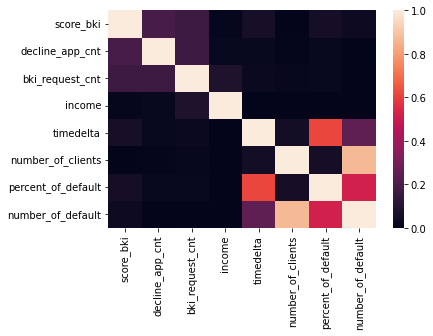

In [46]:
# Построим тепловую карту матрицы корреляций непрерывных признаков. Интересно, что timedelta сильно 
# скореллировано с percent_of_default (коэффициент корреляции -0.62). 
# Это значит, что с течением времени падает число дефолтных клиентов
# Признак number_of_clients сильно скоррелирован с number_of_default (0.87), а number_of_default сильно 
# скоррелирован с percent_of_default (0.52). Если использовать все эти признаки, качество модели 
# ухудшается. Можно было бы удалить некоторые из признаков, но вместо этого я использую метод главных
# компонент (PCA).
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

In [47]:
# Строим матрицу корреляций признаков, для которых будем искать главные компоненты
pca_columns=['number_of_clients','number_of_default','percent_of_default']
correlation_matrix=data[pca_columns].corr().values

In [48]:
# Находим собственные числа и собственные вектора
B=np.linalg.eig(correlation_matrix)
B

(array([2.03791266, 0.01055159, 0.95153575]),
 array([[-0.60441574, -0.6084903 , -0.514219  ],
        [-0.6983878 ,  0.71526496, -0.0255051 ],
        [-0.38332244, -0.34370859,  0.8572796 ]]))

In [49]:
# Центрируем и нормируем признаки
mean_1=data['number_of_clients'].mean()
len_1=np.linalg.norm(data['number_of_clients'])
data['number_of_clients']=data['number_of_clients'] - mean_1
data['number_of_clients']=data['number_of_clients']/len_1

mean_2=data['number_of_default'].mean()
len_2=np.linalg.norm(data['number_of_default'])
data['number_of_default']=data['number_of_default'] - mean_2
data['number_of_default']=data['number_of_default']/len_2

mean_3=data['percent_of_default'].mean()
len_3=np.linalg.norm(data['percent_of_default'])
data['percent_of_default']=data['percent_of_default'] - mean_3
data['percent_of_default']=data['percent_of_default']/len_3

In [50]:
# Создаем новый признак
data['pca_component']=B[1][0][0]*data['number_of_clients']+B[1][1][0]*data['number_of_default']+B[1][2][0]*data['percent_of_default']

In [51]:
# data.drop(columns=['pca_component'], inplace=True)

In [52]:
data.drop(columns=['percent_of_default','number_of_default','number_of_clients'],axis=1,inplace=True)

In [53]:
# data[num_cols].corr()

In [54]:
# Удаляем старые признаки
# data.drop(columns=['percent_of_default','number_of_default','number_of_clients'],axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


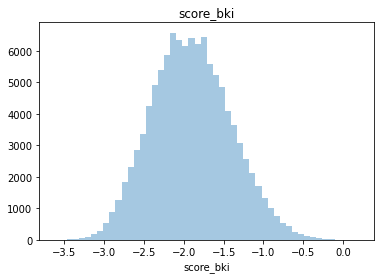

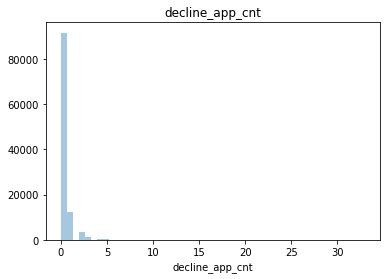

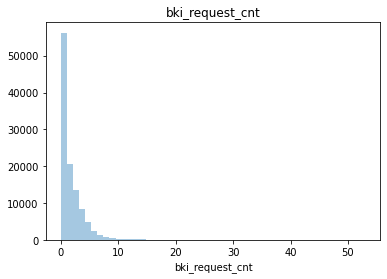

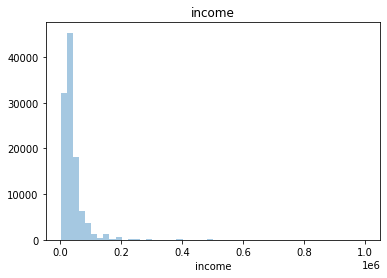

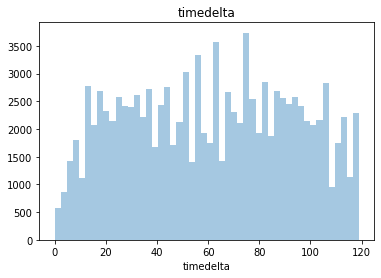

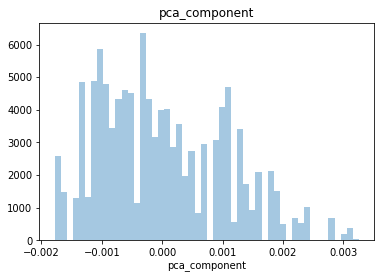

In [55]:
# Нарисуем графики непрерывных признаков
for i in ['score_bki','decline_app_cnt','bki_request_cnt','income','timedelta','pca_component']:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [56]:
# Прологарифмируем признаки, у которых "тяжелый" правый хвост
data['decline_app_cnt']=data['decline_app_cnt'].apply(lambda x: np.log(x+1))
data['bki_request_cnt']=data['bki_request_cnt'].apply(lambda x: np.log(x+1))
data['income']=data['income'].apply(lambda x: np.log(x+1))

In [57]:
from sklearn.preprocessing import PolynomialFeatures

In [58]:
# Попробуем добавить полиномиальные признаки
# pf=PolynomialFeatures(2)
# poly_features=pf.fit_transform(data[['age','decline_app_cnt', 'income']])
# poly_features.shape

In [59]:
# Работа модели показала, что добавление полиномиальных признаков ухудшает модель. 
# Поэтому я закомментировала этот кусок кода
# index=data.index
# right=pd.DataFrame(poly_features, columns=['1','2','3','4','5','6','7','8','9','10'], index=index)
# data=data.join(right, how='inner')
# data.drop(columns=['1','2','3','4','6','7','8','9','10'], inplace=True)

In [60]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default', 'app_month',
       'app_day', 'app_day_of_week', 'timedelta', 'pca_component'],
      dtype='object')

In [61]:
# Попробуем сделать Polynomial Features  вручную
# Некоторые полиномиальные признаки ухудшают модель, поэтому я закомментировала некоторые куски кода.
data['n1']=data['decline_app_cnt']*data['bki_request_cnt']*data['score_bki']
# data['n2']=data['decline_app_cnt']**2 + data['bki_request_cnt']*data['score_bki']
# data['n3']=data['decline_app_cnt']*data['bki_request_cnt'] + data['score_bki']**2
# data['n4']=data['decline_app_cnt']*data['score_bki'] + data['bki_request_cnt']**2
# data['n5']=data['decline_app_cnt']**2 + data['score_bki']**2 + data['bki_request_cnt']**2

# data['n6']=data['home_address']**2 - data['work_address']*data['region_rating']
# data['n7']=data['region_rating']**2 - data['home_address']*data['work_address']
# data['n8']=data['work_address']**2 - data['home_address']*data['region_rating']

data['n9']=data['sna']*data['first_time']
data['n10']=data['sna'] - data['first_time']


# data['n11']=data['income']/data['region_rating']
# data['n12']=data['timedelta']/data['first_time']

In [62]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'sample', 'default', 'app_month',
       'app_day', 'app_day_of_week', 'timedelta', 'pca_component', 'n1', 'n9',
       'n10'],
      dtype='object')

<AxesSubplot:>

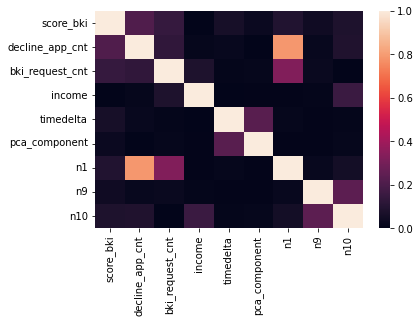

In [63]:
# polynomial_columns=['score_bki', 'bki_request_cnt','income','timedelta', 'pca_component', 'n1',
#        'n3', 'n9', 'n10']

poly_columns=['score_bki','decline_app_cnt', 'bki_request_cnt','income','timedelta', 'pca_component','n1','n9','n10']
sns.heatmap(data[poly_columns].corr().abs(), vmin=0, vmax=1)

In [64]:
# data.drop(columns=['age'],axis=1,inplace=True)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         109670 non-null  object        
 3   sex               110148 non-null  object        
 4   car               110148 non-null  object        
 5   car_type          110148 non-null  object        
 6   decline_app_cnt   110148 non-null  float64       
 7   good_work         110148 non-null  int64         
 8   score_bki         110148 non-null  float64       
 9   bki_request_cnt   110148 non-null  float64       
 10  region_rating     110148 non-null  int64         
 11  home_address      110148 non-null  int64         
 12  work_address      110148 non-null  int64         
 13  income            110148 non-null  float64       
 14  sna 

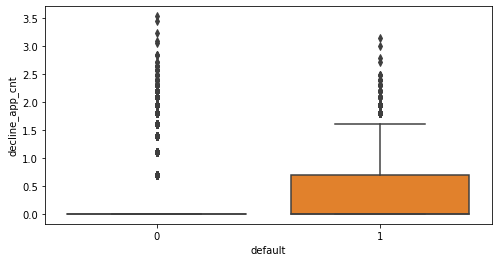

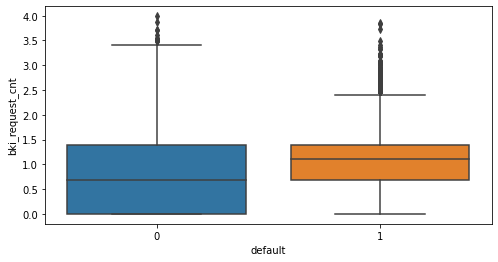

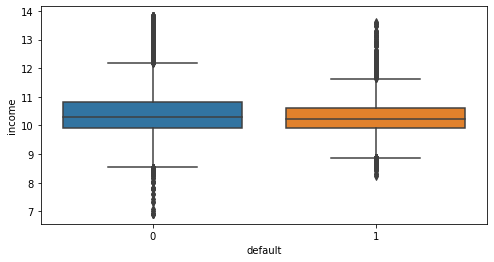

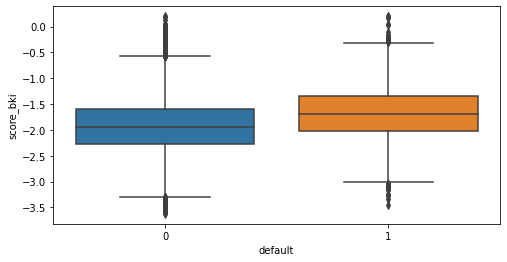

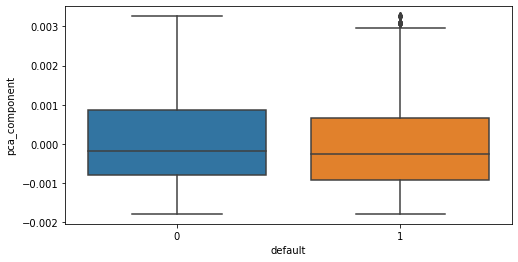

In [66]:
# Нарисуем boxplot для непрерывных переменных (отдельно для дефолтных и для недефолтных клиентов)
for i in ['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component']:
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot1 = sns.boxplot(x=data["default"], y=data[i], data=data,ax=ax)

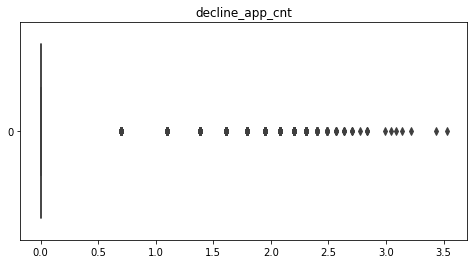

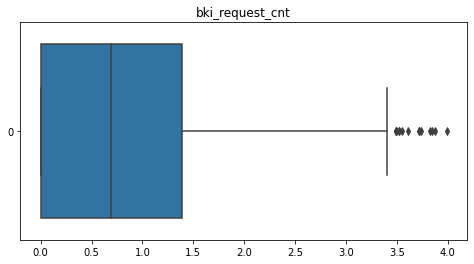

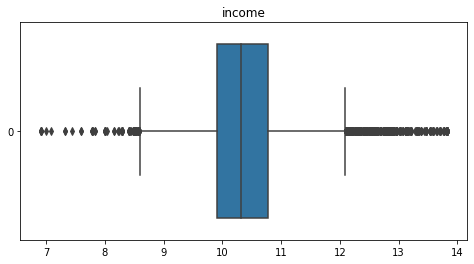

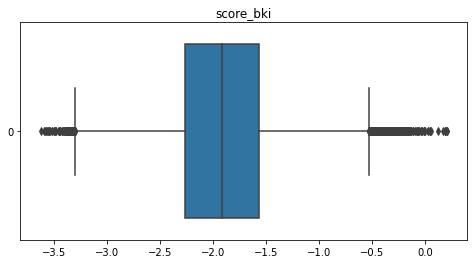

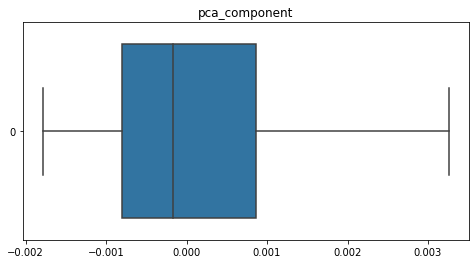

In [67]:
# Теперь нарисуем те же графики для обоих типов клиентов, чтобы понять, что делать с выбросами.
for i in ['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data[i], orient="h")
    plt.title(i)
    plt.show()

In [68]:
# Посчитаем количество выбросов в колонках
count_outliers=[]
percent_outliers=[]
for j in ['score_bki', 'bki_request_cnt', 'income','pca_component']:
    borders=IQR_outliers(j)
#     print(j,':',borders)
    count=0
    for i in range(0,len(data)):
        if data[j][i]<borders[0] or data[j][i]>borders[1]:
            count+=1
    percent=(count/data.shape[0])*100
    print(j,':',count, ',',percent)
    count_outliers.append(count)
    percent_outliers.append(percent)
print(count_outliers,'\n')
print(percent_outliers)

score_bki : 518 , 0.47027635544903224
bki_request_cnt : 15 , 0.01361804118095653
income : 2609 , 2.3686312960743727
pca_component : 0 , 0.0
[518, 15, 2609, 0] 

[0.47027635544903224, 0.01361804118095653, 2.3686312960743727, 0.0]


**Практика показала, что замена выбросов на медиану ухудшает модель (см. код ниже). В этой связи я закомментировала данный кусок кода. Все точки, которые метод IQR определил как выбросы, нужно оставить. В процентном соотношении выбросов немного (от 0.01 до 2.4%)**

In [69]:
# medians=[data['score_bki'].median(),data['bki_request_cnt'].median(),data['income'].median()]
# outliers1=IQR_outliers('score_bki')
# outliers2=IQR_outliers('bki_request_cnt')
# outliers3=IQR_outliers('income')
# print('score_bki:',outliers1,'\n','bki_request_cnt:',outliers2,'\n','income:',outliers3)
# borders={'score_bki':outliers1,'bki_request_cnt':outliers2,'income':outliers3}
# data['score_bki']=data['score_bki'].apply(lambda x: medians[0] if x<borders['score_bki'][0] or x>borders['score_bki'][1] else x)
# data['bki_request_cnt']=data['bki_request_cnt'].apply(lambda x: medians[1] if x<borders['bki_request_cnt'][0] or x>borders['bki_request_cnt'][1] else x)
# data['income']=data['income'].apply(lambda x: medians[2] if x<borders['income'][0] or x>borders['income'][1] else x)

In [70]:
data.shape

(110148, 27)

<AxesSubplot:>

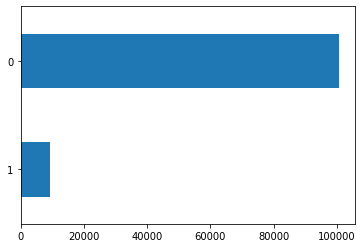

In [71]:
# Посмотрим, сколько у нас всего дефолтных и недефолтных клиентов. Количество классов явно не сбалансировано.
data['default'].value_counts(ascending=True).plot(kind='barh')

In [72]:
# Избавимся от признаков client_id и app_date
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [73]:
# Применим метод get_dummies для колонки education. В отдельную колонку вынесем пропуски
# data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [74]:
data.head()

,education,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,sample,default,app_month,app_day,app_day_of_week,timedelta,pca_component,n1,n9,n10
0,GRD,M,Y,Y,0.000000,0,-2.271884,1.386294,50,1,...,0,0,3,22,5,80,0.000659,-0.000000,4,-3
1,SCH,F,N,N,1.791759,0,-1.504999,1.098612,50,1,...,0,0,1,24,4,23,-0.000043,-2.962514,12,1
2,UGR,M,Y,Y,0.000000,0,-1.691339,0.693147,50,1,...,0,0,3,23,6,81,0.001045,-0.000000,3,-2
3,SCH,M,N,N,0.000000,0,-2.374182,0.693147,40,1,...,0,0,2,3,0,33,-0.000988,-0.000000,3,-2
4,GRD,F,N,N,0.000000,0,-2.487502,0.000000,80,2,...,0,0,2,4,1,34,-0.000694,-0.000000,3,-2


In [75]:
import random

In [76]:
# Заполним пропуски в колонке education. Практика показала, что эту колонку лучше обрабатывать не 
# с помощью get_dummies, а с помощью OneHotEncoder. Для этого необходимо отсутствие пропусков
prob = data['education'].value_counts(normalize=True)
ind = data[data['education'].isna()==True].index
fill_list = pd.Series(random.choices(prob.index, prob, k=data['education'].isna().sum()))
fill_list.index = ind
data['education']=data['education'].fillna(fill_list)

In [77]:
# Функция, заменяющая строковые значения в колонке education на числа (категории). Отмечу, что у меня
# есть сомнения на счет этой функции. Как я могу быть уверена, что 'UGR' действительно по уровню ниже
# 'GRD', а 'PGR' выше 'GRD'? Я заполнила так, как мне кажется верным, но до конца уверенности нет.
def replace_values(string):
    if string=='SCH':
        return 0
    elif string=='UGR':
        return 1
    elif string=='GRD':
        return 2
    elif string=='PGR':
        return 3
    elif string=='ACD':
        return 4

In [78]:
# Заменим строковые значения в колонке education
data['education']=data['education'].apply(replace_values)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  int64  
 1   sex               110148 non-null  object 
 2   car               110148 non-null  object 
 3   car_type          110148 non-null  object 
 4   decline_app_cnt   110148 non-null  float64
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   region_rating     110148 non-null  int64  
 9   home_address      110148 non-null  int64  
 10  work_address      110148 non-null  int64  
 11  income            110148 non-null  float64
 12  sna               110148 non-null  int64  
 13  first_time        110148 non-null  int64  
 14  foreign_passport  110148 non-null  object 
 15  sample            110148 non-null  int64  
 16  default           11

In [80]:
# Применим Label_Encoder для бинарных признаков

# binary_cols = ['sex','car', 'car_type', 'good_work', 'foreign_passport']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# ohe=preprocessing.OneHotEncoder(sparse=False)

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
# Для категориальных признаков применим OneHotEncoder. Сделаем это чуть позже

In [81]:
data.sample(10)

,education,sex,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,sample,default,app_month,app_day,app_day_of_week,timedelta,pca_component,n1,n9,n10
6367,0,0,0,0,0.000000,0,-2.203095,0.000000,50,1,...,0,0,1,22,2,21,-0.000724,-0.000000,3,-2
14956,0,0,0,0,0.000000,0,-2.342188,1.098612,50,2,...,0,0,3,7,4,65,0.000090,-0.000000,8,-2
65908,0,1,1,1,0.000000,0,-2.652237,0.000000,70,1,...,1,0,2,17,0,47,-0.000481,-0.000000,4,-3
68014,2,0,0,0,0.000000,0,-2.423764,0.000000,50,2,...,1,0,4,7,0,96,-0.001095,-0.000000,4,-3
95931,0,0,0,0,0.000000,0,-1.482694,1.098612,40,2,...,1,1,1,26,6,25,0.000660,-0.000000,3,-2
37189,1,0,0,0,0.000000,1,-2.031089,2.302585,60,2,...,1,0,3,26,2,84,0.001822,-0.000000,2,1
27038,1,0,0,0,1.098612,0,-2.424703,1.098612,80,2,...,0,0,1,27,0,26,-0.001000,-2.926493,4,-3
31615,2,0,1,1,0.000000,0,-2.468581,0.000000,50,1,...,0,0,2,7,4,37,-0.000053,-0.000000,2,-1
49590,2,0,0,0,0.000000,0,-2.407383,1.098612,70,1,...,1,0,3,13,3,71,-0.000977,-0.000000,3,-2
85819,1,1,1,0,0.000000,1,-1.555869,0.000000,40,2,...,1,0,4,2,2,91,-0.001397,-0.000000,3,-2


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  int64  
 1   sex               110148 non-null  int64  
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  float64
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   region_rating     110148 non-null  int64  
 9   home_address      110148 non-null  int64  
 10  work_address      110148 non-null  int64  
 11  income            110148 non-null  float64
 12  sna               110148 non-null  int64  
 13  first_time        110148 non-null  int64  
 14  foreign_passport  110148 non-null  int64  
 15  sample            110148 non-null  int64  
 16  default           11

In [83]:
data.columns

Index(['education', 'sex', 'car', 'car_type', 'decline_app_cnt', 'good_work',
       'score_bki', 'bki_request_cnt', 'region_rating', 'home_address',
       'work_address', 'income', 'sna', 'first_time', 'foreign_passport',
       'sample', 'default', 'app_month', 'app_day', 'app_day_of_week',
       'timedelta', 'pca_component', 'n1', 'n9', 'n10'],
      dtype='object')

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [86]:
from itertools import combinations

In [87]:
# Функция для подбора наилучших полиномиальных признаков. Будем комбиринровать колонки с непрерывным
# типом данных по три штуки и создавать на их основе Polynomial Features. Как сделать комбинации,
# описано ниже в закомментированном куске кода.
def find_polynomial_features(df,cols):
    pf=PolynomialFeatures(2)
    poly_features=pf.fit_transform(df[cols])
    index=df.index
    right=pd.DataFrame(poly_features, columns=['1','2','3','4','5','6','7','8','9','10'], index=index)
    right.drop(columns=['1','2','3','4'], inplace=True)
    df=df.join(right, how='inner')
    
    train_data = df.query('sample == 1').drop(['sample'], axis=1)
#     test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)
    y = train_data['default'].values  # наш таргет
    X = train_data.drop(['default'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X1=X_train[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','number_of_clients','timedelta','5','6','7','8','9','10']].values
    X2=X_test[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','number_of_clients','timedelta','5','6','7','8','9','10']].values
    
    scaler=RobustScaler()
    X1_transformed=scaler.fit_transform(X1)
    X2_transformed=scaler.transform(X2)
    X_train[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','number_of_clients','timedelta','5','6','7','8','9','10' ]]=X1_transformed
    X_test[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','number_of_clients','timedelta','5','6','7','8','9','10']]=X2_transformed
    
    model = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', penalty='l2', tol=0.001, multi_class='ovr')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    return metrics.f1_score(y_test,y_pred)

In [88]:
# В ходе работы этого цикла было обнаружено, что наибольшее значение метрики f1_score получается при
# использовании комбинации ['age', 'decline_app_cnt', 'income'] для создания полиномиальных признаков. 
# Я закомментировала этот кусок кода, т.к. нет необходимости запускать его каждый раз. Обучение модели 
# на каждом шаге цикла занимает слишком много времени.
# Более того, было показано, что добавление полиномиальных признаков ухудшает модель. Поэтому было 
# решено от них отказаться.
# columns=['age','decline_app_cnt',
#        'score_bki', 'bki_request_cnt', 'income',
#        'timedelta', 'number_of_clients']
# cand=find_polynomial_features(data,['age', 'decline_app_cnt', 'score_bki'])
# columns_best=['age', 'decline_app_cnt', 'score_bki']
# for i in combinations(columns,3):    
#     f1_score_current=find_polynomial_features(data,list(i))
#     print('For the following columns: ',i,' f1_score=', f1_score_current,'\n')
#     if f1_score_current>cand:
#         cand=f1_score_current
#         columns_best=i
# print(cand)
# print(columns_best)

In [89]:
from sklearn.feature_selection import f_classif

<AxesSubplot:>

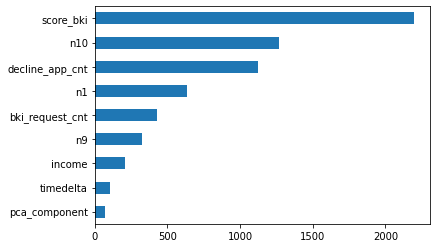

In [90]:
# У меня получился результат, отличный от полученного в модуле. Самым важным среди непрерывных
# признаков является score_bki
cols=['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income','timedelta','pca_component', 'n1','n9','n10']
imp_num = pd.Series(f_classif(data[cols], data['default'])[0], index = cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [91]:
from sklearn.feature_selection import mutual_info_classif

<AxesSubplot:>

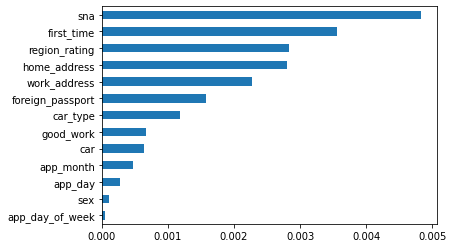

In [92]:
# У меня получился результат, отличный от полученного в модуле. Самым важным среди категориальных и 
# бинарных признаков является sna
other_cols = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'app_day_of_week']

imp_cat = pd.Series(mutual_info_classif(data[other_cols], data['default'],
                                     discrete_features =True), index = other_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [93]:

# data.drop(columns=['sna','sex','age'],axis=1, inplace=True)

**Прменение модели**

In [94]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

In [95]:
from sklearn.model_selection import StratifiedShuffleSplit

In [96]:
# Я попробовала использовать разбиение выборки с помощью StratifiedShuffleSplit. Это не привело к
# улучшению целевой метрики. Поэтому я вернулась к train_test_split.
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
# train_indices, valid_indices = [split for split in sss.split(train_data.drop(['default'],axis=1), train_data['default'])][0]

# X1=train_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']].values
# X2=test_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']].values

# scaler=RobustScaler()
# X1_transformed=scaler.fit_transform(X1)
# X2_transformed=scaler.transform(X2)

# train_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']]=X1_transformed
# test_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']]=X2_transformed

# s_train = train_data.iloc[train_indices]
# s_valid = train_data.iloc[valid_indices]

# numeric_cols=['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']

# from sklearn.preprocessing import OneHotEncoder

# columns = ['education','first_time', 'sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','app_day_of_week']
# ohe_train_train=OneHotEncoder(sparse=False)
# X_cat_train_train = ohe_train_train.fit_transform(s_train[columns].values)

# ohe_train_test=OneHotEncoder(sparse=False)
# X_cat_train_test = ohe_train_test.fit_transform(s_valid[columns].values)

# ohe_test=OneHotEncoder(sparse=False)
# X_cat_test=ohe_test.fit_transform(test_data[columns].values)

# X_train=np.hstack([s_train[numeric_cols].values, s_train[bin_cols].values, X_cat_train_train])
# X_test=np.hstack([s_valid[numeric_cols].values, s_valid[bin_cols].values, X_cat_train_test])

# y_train=s_train['default'].values
# y_test=s_valid['default'].values

# X_train=pd.DataFrame(X_train, columns=[i for i in range(0,80)], index=[j for j in range(0,59039)])
# X_test=pd.DataFrame(X_test, columns=[i for i in range(0,80)], index=[j for j in range(0,14760)])
# X=X_train.append(X_test,sort=False).reset_index(drop=True)

# y_train=pd.DataFrame(y_train, columns=['0'], index=[j for j in range(0,59039)])
# y_test=pd.DataFrame(y_test, columns=['0'], index=[j for j in range(0,14760)])
# y=y_train.append(y_test,sort=False).reset_index(drop=True)

# X_valid=np.hstack([X2_transformed,test_data[bin_cols], X_cat_test])

In [97]:
# Проведем обработку категориальных признаков отдельно в test и train. Используем для этого 
# OneHotEncoder. Практика показала, что это дает увеличение целевой метрики по сравнению с 
# использованием необработанных категориальных признаков.

from sklearn.preprocessing import OneHotEncoder

columns = ['education','first_time','sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','app_day_of_week']
ohe_train=OneHotEncoder(sparse=False)
X_cat_train = ohe_train.fit_transform(train_data[columns].values)

ohe_test=OneHotEncoder(sparse=False)
X_cat_test=ohe_test.fit_transform(test_data[columns].values)

In [98]:
# Обработаем по отдельности колонки c непрерывным типом данных из train и test
X1=train_data[['decline_app_cnt','bki_request_cnt','income', 'score_bki', 'timedelta','pca_component','n1','n9','n10']].values
X2=test_data[['decline_app_cnt','bki_request_cnt','income', 'score_bki','timedelta','pca_component','n1','n9','n10']].values

In [99]:
# Пропустим через RobustScaler все колонки с непрерывным типом данных. Я выбрала RobustScaler, потому что
# он нечувствителен к выбросам и дает лучший результат в Kaggle, чем StandardScaler. 
# Обработаем отдельно колонки из test и train
scaler=RobustScaler()
X1_transformed=scaler.fit_transform(X1)
X2_transformed=scaler.transform(X2)

In [100]:
# Запишем в датасет нормализованные значения колонок
train_data[['decline_app_cnt','bki_request_cnt','income', 'score_bki', 'timedelta','pca_component','n1','n9','n10']]=X1_transformed
test_data[['decline_app_cnt','bki_request_cnt','income', 'score_bki','timedelta','pca_component','n1','n9','n10']]=X2_transformed

In [101]:
# Составим матрицу независимых переменных для train и валидации
X=np.hstack([X1_transformed, train_data[bin_cols].values, X_cat_train])
X_valid=np.hstack([X2_transformed,test_data[bin_cols], X_cat_test])

In [102]:
y = train_data['default'].values  # наш таргет
# X = train_data.drop(['default'], axis=1)

In [103]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 82), (14760, 82), (59039,), (14760,))

In [105]:
# scaler=RobustScaler()
# X_train=scaler.fit_transform(X_train)
# X_test=scaler.transform(X_test)

In [106]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   education         110148 non-null  int64  
 1   sex               110148 non-null  int64  
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  float64
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   region_rating     110148 non-null  int64  
 9   home_address      110148 non-null  int64  
 10  work_address      110148 non-null  int64  
 11  income            110148 non-null  float64
 12  sna               110148 non-null  int64  
 13  first_time        110148 non-null  int64  
 14  foreign_passport  110148 non-null  int64  
 15  sample            110148 non-null  int64  
 16  default           11

In [108]:
# C_list =np.arange(0.01, 1.01, 0.01)
# max_f1 = -1
# max_C = -1
# for c in C_list:
#     model = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', penalty='l2', tol=0.001, multi_class='ovr', C=c)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     f1 = metrics.f1_score(y_test, y_pred)
#     if f1 > max_f1:
#         max_f1 = f1
#         max_C= c
# print(max_C, max_f1)

In [109]:
# Создадим модель в оптимальными параметрами, найденными с помощью инструмента GridSearchCV
# Ниже я закомментировала запуск кода с GridSearchCV, т.к. он требует очень много времени.
# Найти оптимальные параметры достаточно один раз. Нет необходимости запускать этот кусок кода 
# каждый раз при запуске ноутбука. Единственное, что я изменила - это количество итераций. GridSearchCV
# каждый раз запускался с количеством итераций 50. Я изменила это число на 1000 в итоговой модели.
# Это дает лучший результат.
logreg = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', penalty='l2', C=0.01, tol=0.001, multi_class='ovr')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test) 
Y_pred=logreg.predict(X_train)
y_pred_proba=logreg.predict_proba(X_test)
y_pred_proba=y_pred_proba[:,1]
Y_pred_proba=logreg.predict_proba(X_train)
Y_pred_proba=Y_pred_proba[:,1]

**Вот найденные методом GridSearchCV оптимальные параметры модели:**
* C: 1.0 (параметр по умолчанию)
* class_weight: 'balanced' (подобрано, по умолчанию None)
* dual: False (по умолчанию)
* fit_intercept: True (по умолчанию)
* intercept_scaling: 1 (по умолчанию)
* l1_ratio: None (по умолчанию)
* max_iter: 50 (установлено нами)
* multi_class: 'ovr' (подобрано, по умолчанию auto)
* n_jobs: None (по умолчанию)
* penalty: 'l2' (по умолчанию)
* random_state: None (по умолчанию)
* solver: 'saga' (подобрано, по умолчанию lbfgs)
* tol: 0.001 (подобрано, по умолчанию 0.0001)
* verbose: 0 (по умолчанию)
* warm_start: False (по умолчанию)

In [110]:
# Импортируем все необходимые метрики
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, roc_auc_score, recall_score, confusion_matrix

In [111]:
# Напишем функцию, которая будет отображать нам значения всех метрик на тренировочной выборке и на тестовой
def show_metrics(y_pred_train, Y_train, y_pred_test, Y_test, y_pred_proba_train, y_pred_proba_test):
    f1_score_train=f1_score(y_pred_train,Y_train)
    f1_score_test=f1_score(y_pred_test,Y_test)
    print('[train] f1_score {0:.2f}, [test] f1_score {1:.2f}\n'.format(f1_score_train,f1_score_test))
    precision_score_train=precision_score(y_pred_train,Y_train)
    precision_score_test=precision_score(y_pred_test,Y_test)
    print('[train] precision_score {0:.2f}, [test] precision_score {1:.2f}\n'.format(precision_score_train,precision_score_test))
    recall_score_train=recall_score(y_pred_train,Y_train)
    recall_score_test=recall_score(y_pred_test,Y_test)
    print('[train] recall_score {0:.2f}, [test] recall_score {1:.2f}\n'.format(recall_score_train,recall_score_test))
    accuracy_score_train=accuracy_score(y_pred_train,Y_train)
    accuracy_score_test=accuracy_score(y_pred_test,Y_test)
    print('[train] accuracy_score {0:.2f}, [test] accuracy_score {1:.2f}\n'.format(accuracy_score_train,accuracy_score_test))
    roc_auc_score_train=roc_auc_score(Y_train,y_pred_proba_train)
    roc_auc_score_test=roc_auc_score(Y_test,y_pred_proba_test)
    print('[train] roc_auc_score {0:.2f}, [test] roc_auc_score {1:.2f}\n'.format(roc_auc_score_train,roc_auc_score_test))
    confusion_matrix_train=confusion_matrix(y_pred_train,Y_train)
    confusion_matrix_test=confusion_matrix(y_pred_test,Y_test)
    print('[train] confusion_matrix \n {0}, \n[test] confusion_matrix \n {1}\n'.format(confusion_matrix_train,confusion_matrix_test))

In [112]:
# Проверим, нет ли переобучения модели
show_metrics(Y_pred,y_train,y_pred,y_test,Y_pred_proba,y_pred_proba)

[train] f1_score 0.34, [test] f1_score 0.34

[train] precision_score 0.67, [test] precision_score 0.68

[train] recall_score 0.23, [test] recall_score 0.23

[train] accuracy_score 0.67, [test] accuracy_score 0.67

[train] roc_auc_score 0.74, [test] roc_auc_score 0.74

[train] confusion_matrix 
 [[34639  2495]
 [16855  5050]], 
[test] confusion_matrix 
 [[8703  582]
 [4230 1245]]



In [113]:
# Кажется, переобучения нет. Чтобы проверить это, воспользуемся функцией cross_validate 
# из обучающего модуля

from sklearn.model_selection import cross_validate
cv_metrics = cross_validate(logreg, X, y, cv=5, scoring='f1_micro', return_train_score=True)

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

[train] F1-score = 0.67 +/- 0.00
[valid] F1-score = 0.67 +/- 0.00


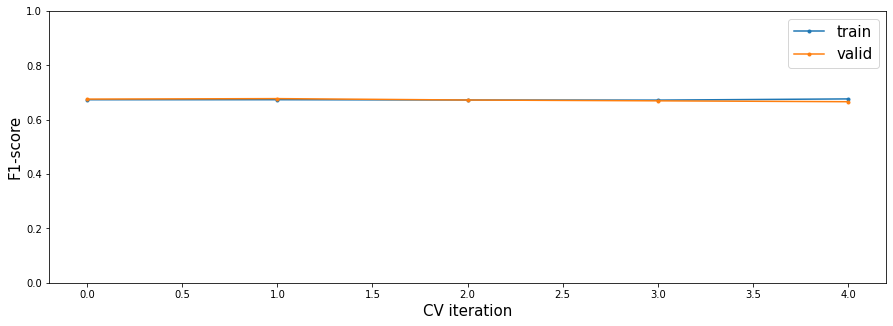

In [114]:
plot_cv_metrics(cv_metrics)
# Похоже, переобучения действительно нет

In [115]:
from sklearn.model_selection import GridSearchCV

In [116]:
# Запутим подбор параметров модели, как в обучающем модуле
# model=LogisticRegression()

# iter_ = 50
# epsilon_stop = 1e-3

# param_grid = [   {'penalty': ['l1'], 
#      'solver': ['liblinear', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['l2'], 
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
#     {'penalty': ['none'], 
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[iter_],
#      'tol':[epsilon_stop]},
# ]

## model ваша модель логистической регрессии
# gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
# gridsearch.fit(X_train, y_train)
# model = gridsearch.best_estimator_

##печатаем параметры
# best_parameters = model.get_params()
# for param_name in sorted(best_parameters.keys()):
#         print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [117]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', penalty='l2',tol=0.001, multi_class='ovr')
# logreg_final = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
logreg_final.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr',
                   solver='saga', tol=0.001)

In [118]:
# Это лишнее! test_data уже обработана
# test_data['decline_app_cnt']=test_data['decline_app_cnt'].apply(lambda x: np.log(x+1))
# test_data['bki_request_cnt']=test_data['bki_request_cnt'].apply(lambda x: np.log(x+1))
# test_data['income']=test_data['income'].apply(lambda x: np.log(x+1))

In [119]:
# Это лишнее! test_data уже обработана
# mean_score_test=test_data['score_bki'].mean()
# test_data['score_bki']=(test_data['score_bki'] - mean_score_test)/np.linalg.norm(test_data['score_bki'])

In [120]:
predict_submission = logreg_final.predict(X_valid)

In [121]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [122]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.374288
std,31706.052195,0.483945
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [123]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


**Выводы:**
* Разведывательный анализ данных показал, что данные достаточно чистые. Пропусков немного (только в колонке education). Пропуски в колонке education были заполнены случайными значениями из уже существующих.
* Колонки в датасете делятся на бинарные, категориальные и с непрерывным типом данных. Бинарные колонки были обработаны с помощью LabelEncoder, категориальные - с помощью OneHotEncoder.
* Некоторые колонки с непрерывным типом данных ('decline_app_cnt','bki_request_cnt','income') имеют "тяжелый" правый хвост. Это колонки были прологарифмированы. Операция была проведена над объединенным датасетом
* Были сгенерированы дополнительные непрерывные признаки (4 колонки) и категориальные признаки (3 колонки). Новые категориальные признаки повышают качество модели. Новые непрерывные признаки сильно скоррелированы, поэтому их использование ухудшает качество модели. Три наиболее скоррелированных признака были обработаны методом главных компонент. Это дало улучшение целевой метрики.
* Была предпринята попытка сгенерировать полиномиальные признаки (вручную и с помощью функции Polynomial Features). Полиномиальные признаки ухудшают модель, поэтому было принято решение от них отказаться. Но: позднее выяснилось, что некоторые полиномиальные признаки просто были сильно скоррелированы. Я оставила только некоторые из них, это дало улучшение модели.
* Работа с выбросами в данном датасете не принесла улучшения качества модели. Выбросы были классифицированы методом IQR. Т.к. удаление выбросов приводит к ухудшению качества модели, выбросы было решено оставить.
* Был использован RobustScaler для нормализации непрерывных признаков.
* Наибольшее значение для модели имеют признаки score_bki и sna.
* Была сделана попытка удалить наименее значимые для модели признаки из числа категориальных и непрерывных. Удаление наименее значимого категориального признака (app_day_of_week) не приводит к улучшению модели. Однако, удаление наименее значимого непрерывного признака (age) улучшает целевую метрику. Если удалить следующий по значимости непрерывный признак (pca_component), то метрика ухудшится.
* Было испробовано добавление параметра WOE и IV для переменных age, sex и sna. Это не принесло улучшения качества модели, поэтому от данных параметров было принято решение отказаться.
* С помощью  метода GridSerchCV были подобраны оптимальные параметры для модели. Оказалось, что оптимальная модель - это Logistic Regression Balanced. 
* Был подобран гиперпараметр С=0.01, что соответствует максимальному вкладу регуляризации. Это дало улучшение целевой метрики по сравнению с С=1.0 (значение по умолчанию).
* Было испробовано деление выборки на обучающую и тестовую с помощью StratifiedShuffleSplit (деление на части с учетом долей классов). Это не дало увеличения целевой метрики. От данного способа деления выборки было принято решение отказаться в пользу train_test_split.
* На обучающей и тестовой выборке были измерены основные метрики (f1_score, precision_score, recall_score, accuracy_score). Т.к. значения метрик на обучающей и на тестовой выборке практически не отличаются, можно сделать вывод, что переобучения модели нет.